<a href="https://colab.research.google.com/github/maciejskorski/new_pll_trng/blob/main/TRNG_Dependency_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data



In [ ]:
# update Python software - and restart the kernel when necessary
!pip install --upgrade statsmodels --quiet
!pip install mlflow --quiet
!pip install pyngrok --quiet

     |████████████████████████████████| 9.8 MB 5.2 MB/s 
     |████████████████████████████████| 16.9 MB 5.5 MB/s 
     |████████████████████████████████| 147 kB 65.8 MB/s 
     |████████████████████████████████| 77 kB 5.4 MB/s 
     |████████████████████████████████| 79 kB 6.7 MB/s 
     |████████████████████████████████| 209 kB 66.7 MB/s 
     |████████████████████████████████| 181 kB 50.2 MB/s 
     |████████████████████████████████| 78 kB 7.2 MB/s 
     |████████████████████████████████| 140 kB 61.3 MB/s 
     |████████████████████████████████| 62 kB 1.1 MB/s 
     |████████████████████████████████| 55 kB 2.7 MB/s 
     |████████████████████████████████| 63 kB 1.5 MB/s 
     |████████████████████████████████| 59 kB 6.0 MB/s 
     |████████████████████████████████| 745 kB 5.4 MB/s 


In [ ]:
# Download the zipped files from the shared internet link:
!curl -L "https://filesender.renater.fr/download.php?token=c4a56006-e8f9-4d78-9357-d4540b99e185&files_ids=17941252" --output data_v1.zip
!unzip -q data_v1.zip -d data_v1
!curl -L "https://filesender.renater.fr/download.php?token=76f39908-16e7-4b6b-b497-5849066c7641&files_ids=17983818" --output data_v2.zip
!unzip -q data_v2.zip -d data_v2
!curl -L "https://filesender.renater.fr/download.php?token=1edb5a92-296e-4833-b71d-86e17568aeba&files_ids=17988708" --output data_v3.zip
!unzip -q data_v3.zip -d data_v3

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 5838k  100 5838k    0     0   533k      0  0:00:10  0:00:10 --:--:--  620k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 13.5M  100 13.5M    0     0   581k      0  0:00:23  0:00:23 --:--:--  613k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 7022k  100 7022k    0     0   575k      0  0:00:12  0:00:12 --:--:--  627k


# Analysis Module

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

from IPython.display import display
from pathlib import Path
import logging


plt.rcParams['figure.figsize'] = (10,3)
logger = logging.getLogger('TRNG Analysis')
logger.setLevel(logging.INFO)


def get_bytes_data(fpath):
  with open(fpath,'rb') as f:
    bytes_data = f.read()
  bytes_data = pd.DataFrame(list(bytes_data),columns=['byte value'])
  bytes_data.index.name = 'timestep'
  return bytes_data


def last_bit(x):
  return x % 2

def diff_last_bit(x):
  return x.diff().loc[1:] % 2


def analyze_series(bytes_data, nlags=10, alpha=0.05, postprocess_fn=last_bit):
  """ Analyze dependencies of TRNG bytes candidate.
      Args:
          bytes_data (pandas.DataFrame): series of raw bytes (das), encoded as integers uint8
          nlags (int): maximum number of lags to analyse
          alpha (float): confidence level for hypothesis testing
          postprocess_fn (function): transform applied to the series. For example, use <mod 2> to extract the last significant bit
      Return:
          figure: picture with plots
  """
  params = {
        'lags':nlags,
        'alpha':alpha,
        'postprocess_fn':postprocess_fn.__name__
  }
  mlflow.log_params(params)
  fig,axs = plt.subplots(1,2,constrained_layout=True)
  # plot histogram
  ax = axs[0]
  sns.histplot(data=bytes_data,x='byte value',ax=ax,discrete=True)
  # plot time series
  ax = axs[1]
  sns.lineplot(data=bytes_data.loc[:1000],x='timestep',y='byte value',ax=ax)
  plt.show()
  mlflow.log_figure(fig,'exploratory.png')
  bytes_data = postprocess_fn(bytes_data)
  # stationarity tests on postprocessed data
  results = kpss(bytes_data,nlags=10)
  pval = results[1]
  mlflow.log_metric(f'stationary.KPSS.lag_{nlags}',pval)
  results = adfuller(bytes_data,maxlag=10)
  pval = results[1]
  mlflow.log_metric(f'not-stationary.ADF.lag_{nlags}',pval)
  # plot autocorelation
  fig,ax = plt.subplots(1,1,constrained_layout=True)
  fig = plot_acf(x=bytes_data, lags = nlags, fft=True, alpha=alpha, bartlett_confint=True, zero=False, adjusted=True, ax=ax, auto_ylims=True)
  ax.set(xlabel='Lag',ylabel='Corr')
  plt.show()
  mlflow.log_figure(fig,'autocorrelation.png')
  # find p-values for autocorrelation
  _,_,_,pvals = acf(
          x=bytes_data,
          nlags=nlags,
          alpha=alpha,
          fft=True,
          bartlett_confint=True,
          adjusted=True,
          qstat=True
  )
  pvals = {'lag':np.arange(1,nlags+1),'Ljung-Box Test p-val':pvals}
  pvals = pd.DataFrame(data=pvals)
  pvals.set_index('lag',inplace=True)
  display(pvals)
  mlflow.log_metric(f'not-correlated.LjungBox.lag_{nlags}',pvals.loc[nlags])

# Results

The conclusions are:


1.   Use the least significant bit to remove correlations. 

2.   Strong evidence for stationarity

In [ ]:
import numpy as np
import scipy
from scipy import stats
path = '/content/data_v3/220929_SFa4_DBv11-12/acq_20220929154848_cnt.bin'
x = np.fromfile(path,dtype='uint8')
corr,pval = scipy.stats.pearsonr(x[:-1],x[1:])
print(f'Counter Raw Value: Correlation={corr}, non-corr test: p-val={pval}')

y = x%2
corr,pval = scipy.stats.pearsonr(y[:-1],y[1:])
print(f'Counter Last Bit: correlation={corr}, non-corr p-val={pval}')

Counter Raw Value: Correlation=-0.050091143944789994, non-corr test: p-val=0.0
Counter Last Bit: correlation=-4.1032083376957556e-05, non-corr p-val=0.9672703750150912


## Logging

Result outcmes are tracked with `mlflow`, and interactively presented under the temporary domain set up with `ngrok`.

In [ ]:
import mlflow
from pyngrok import ngrok
from getpass import getpass

# run mlflow server
get_ipython().system_raw("mlflow ui --port 5000 &")

# Terminate open tunnels if exist
ngrok.kill()

# Setting the authtoken (optional)
# Get your authtoken from https://dashboard.ngrok.com/auth
NGROK_AUTH_TOKEN = getpass('Enter the ngrok authtoken: ')
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

# Open an HTTPs tunnel on port 5000 for http://localhost:5000
ngrok_tunnel = ngrok.connect(addr="5000", proto="http", bind_tls=True,
                             auth="best_pll_trng:Hubert Curien"
                             )
print("MLflow Tracking UI:", ngrok_tunnel.public_url)

Enter the ngrok authtoken: ··········
MLflow Tracking UI: https://8e1c-34-66-252-67.ngrok.io


## Experiments

INFO:TRNG Analysis:Doing experiment data_v1/220928_CVa1


data_v1/220928_CVa1


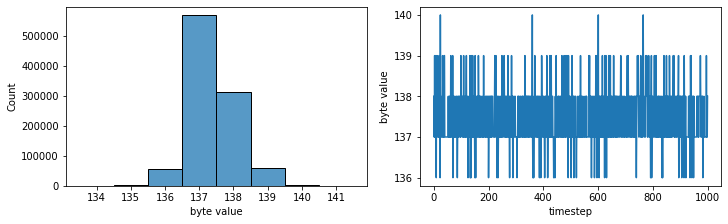

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning


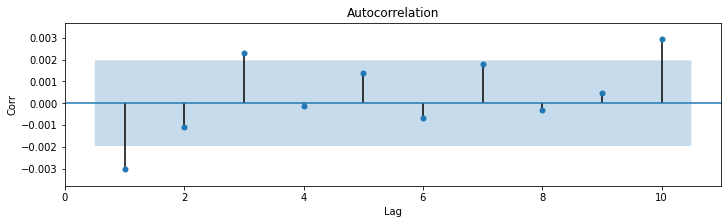

,Ljung-Box Test p-val
lag,
1,0.002499
2,0.005788
3,0.001353
4,0.003530
5,0.003546
6,0.006223
7,0.003487
8,0.006415
9,0.010561


INFO:TRNG Analysis:Doing experiment data_v1/220928_CVa1


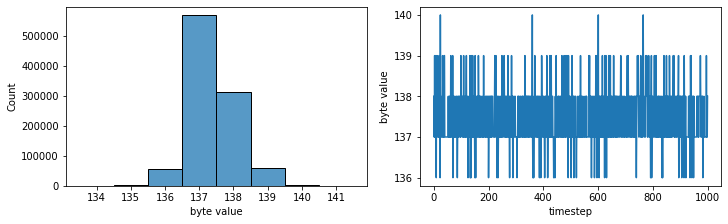

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning


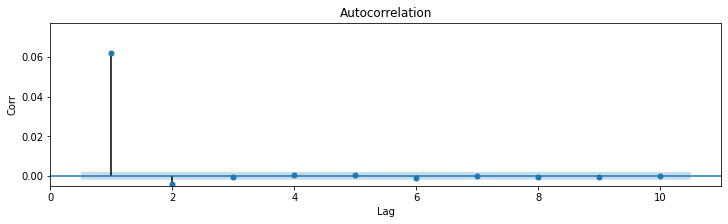

,Ljung-Box Test p-val
lag,
1,0.0
2,0.0
3,0.0
4,0.0
5,0.0
6,0.0
7,0.0
8,0.0
9,0.0


INFO:TRNG Analysis:Doing experiment data_v1/220928_CVa4


data_v1/220928_CVa4


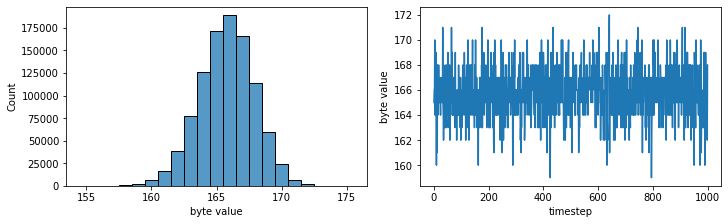

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


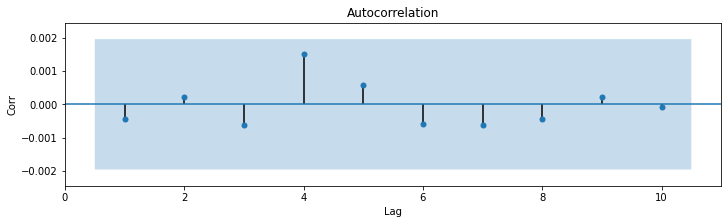

,Ljung-Box Test p-val
lag,
1,0.651972
2,0.880119
3,0.888116
4,0.570924
5,0.662124
6,0.731094
7,0.782401
8,0.842047
9,0.896610


INFO:TRNG Analysis:Doing experiment data_v1/220928_CVa4


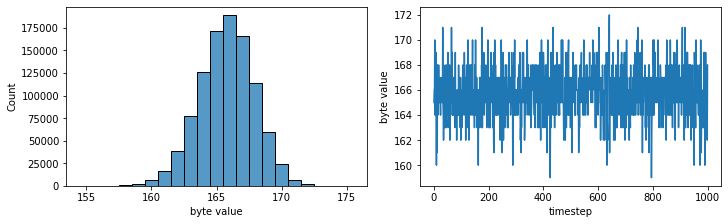

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


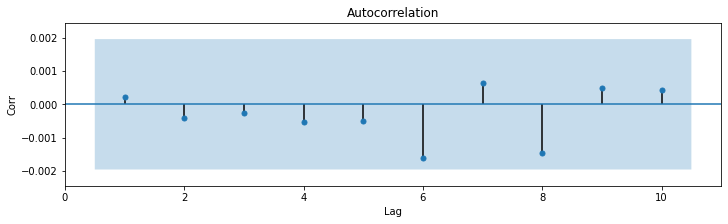

,Ljung-Box Test p-val
lag,
1,0.819804
2,0.899039
3,0.963255
4,0.968437
5,0.977513
6,0.757892
7,0.802597
8,0.650641
9,0.719769


INFO:TRNG Analysis:Doing experiment data_v1/220927_CVa2


data_v1/220927_CVa2


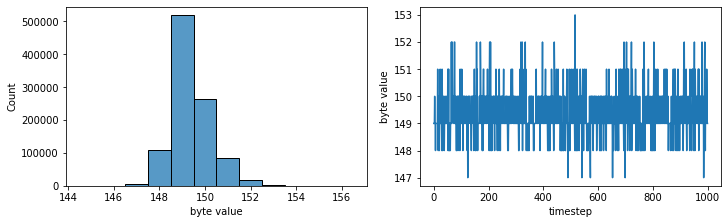

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning


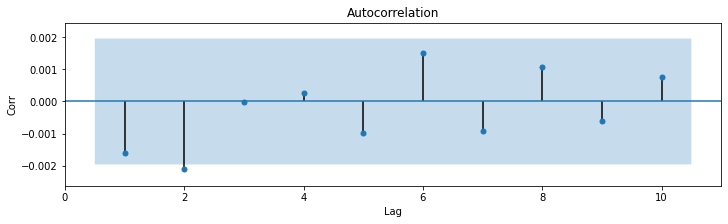

,Ljung-Box Test p-val
lag,
1,0.107761
2,0.030255
3,0.072006
4,0.132591
5,0.153999
6,0.113107
7,0.132529
8,0.138746
9,0.178821


INFO:TRNG Analysis:Doing experiment data_v1/220927_CVa2


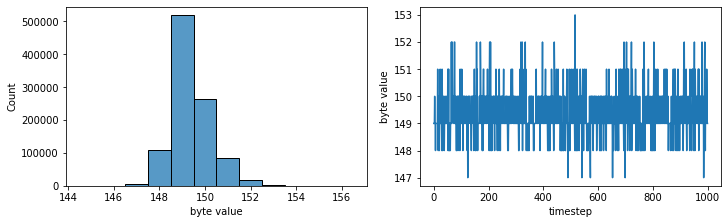

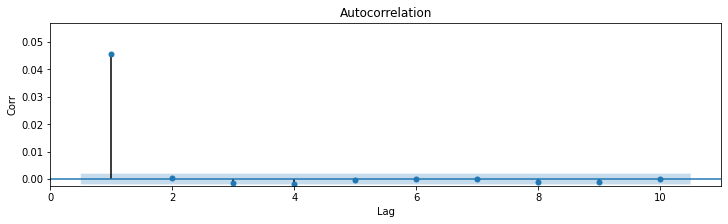

,Ljung-Box Test p-val
lag,
1,0.0
2,0.0
3,0.0
4,0.0
5,0.0
6,0.0
7,0.0
8,0.0
9,0.0


INFO:TRNG Analysis:Doing experiment data_v2/PR_Card_7/220928_CVa1


data_v2/PR_Card_7/220928_CVa1


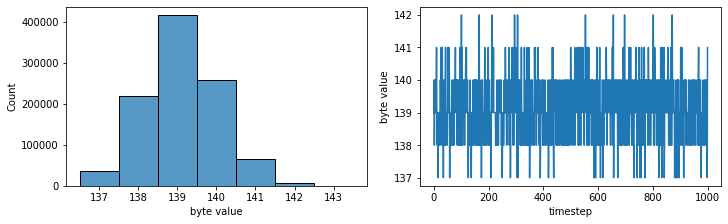

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


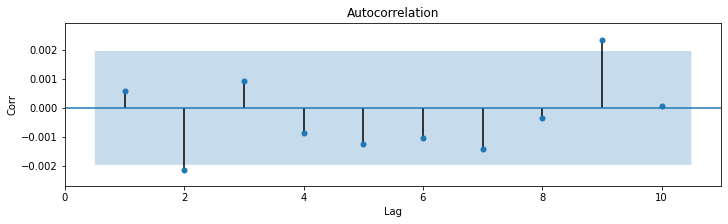

,Ljung-Box Test p-val
lag,
1,0.569122
2,0.085237
3,0.122135
4,0.163041
5,0.153885
6,0.166961
7,0.133388
8,0.188936
9,0.053068


INFO:TRNG Analysis:Doing experiment data_v2/PR_Card_7/220928_CVa1


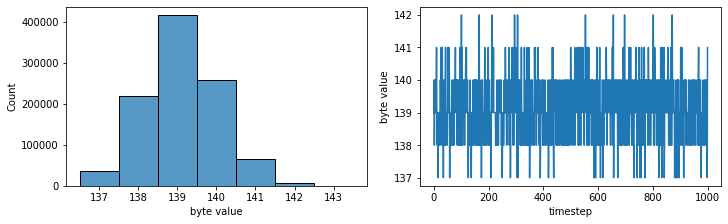

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


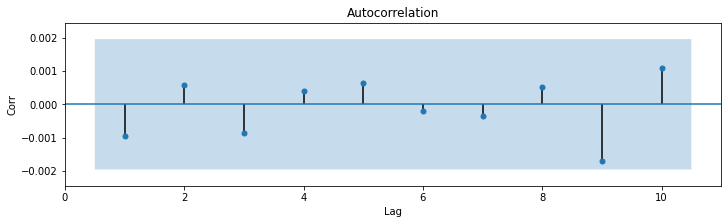

,Ljung-Box Test p-val
lag,
1,0.335511
2,0.529093
3,0.563645
4,0.696808
5,0.759427
6,0.850708
7,0.904950
8,0.931033
9,0.746663


INFO:TRNG Analysis:Doing experiment data_v2/PR_Card_7/220928_CVa4


data_v2/PR_Card_7/220928_CVa4


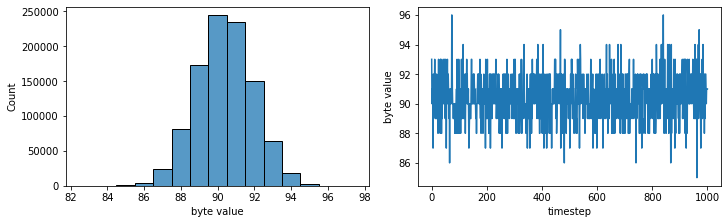

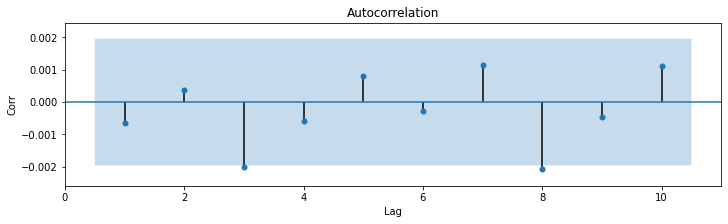

,Ljung-Box Test p-val
lag,
1,0.508444
2,0.748280
3,0.198671
4,0.286215
5,0.341252
6,0.452891
7,0.423605
8,0.182895
9,0.239389


INFO:TRNG Analysis:Doing experiment data_v2/PR_Card_7/220928_CVa4


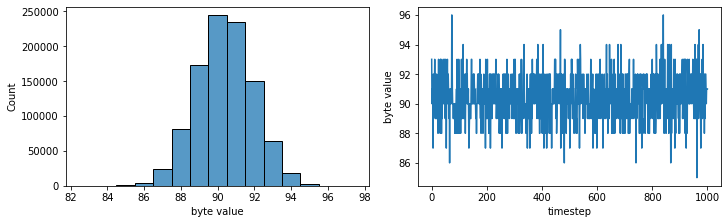

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


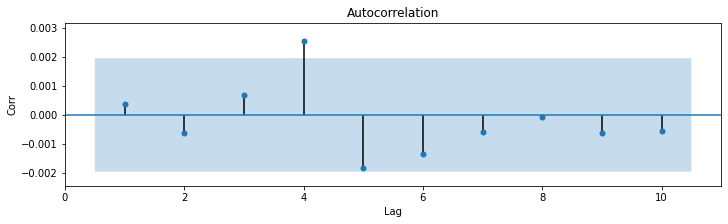

,Ljung-Box Test p-val
lag,
1,0.705753
2,0.768643
3,0.798140
4,0.112250
5,0.055454
6,0.050018
7,0.073895
8,0.114088
9,0.147686


INFO:TRNG Analysis:Doing experiment data_v2/PR_Card_7/220928_CVa2


data_v2/PR_Card_7/220928_CVa2


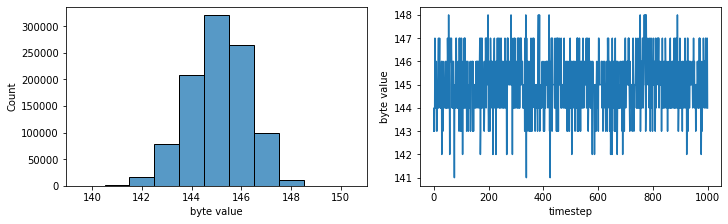

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


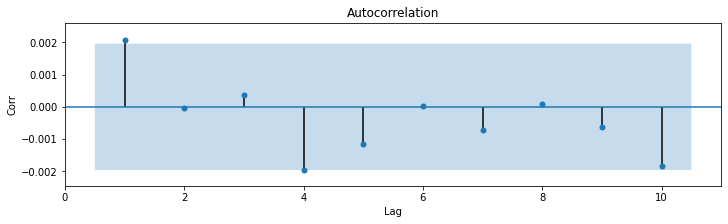

,Ljung-Box Test p-val
lag,
1,0.037013
2,0.113492
3,0.213436
4,0.081856
5,0.087895
6,0.143227
7,0.182250
8,0.256584
9,0.310860


INFO:TRNG Analysis:Doing experiment data_v2/PR_Card_7/220928_CVa2


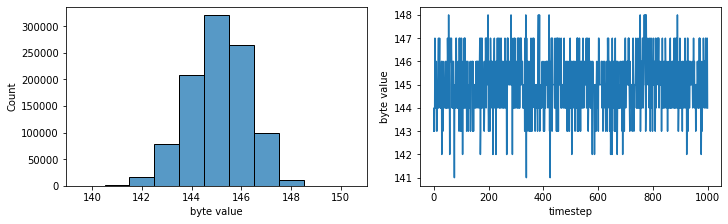

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


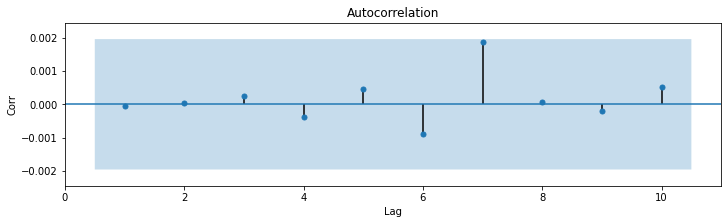

,Ljung-Box Test p-val
lag,
1,0.961426
2,0.997746
3,0.995976
4,0.994689
5,0.994618
6,0.976628
7,0.689116
8,0.782089
9,0.850166


INFO:TRNG Analysis:Doing experiment data_v2/PR_Card_2/220928_CVa1


data_v2/PR_Card_2/220928_CVa1


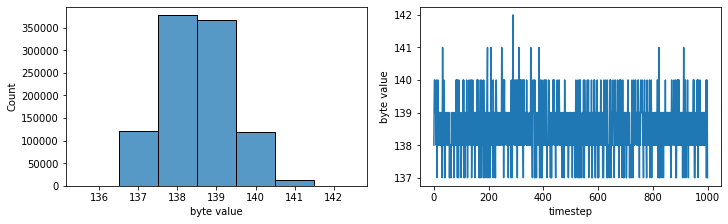

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


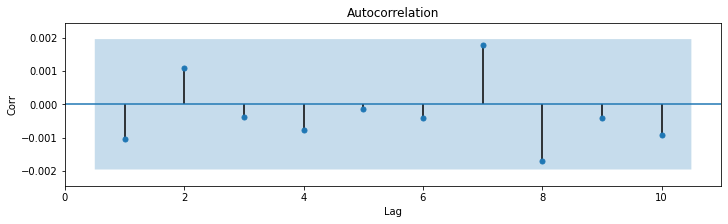

,Ljung-Box Test p-val
lag,
1,0.303671
2,0.326535
3,0.495895
4,0.558553
5,0.697160
6,0.784085
7,0.497482
8,0.322740
9,0.400462


INFO:TRNG Analysis:Doing experiment data_v2/PR_Card_2/220928_CVa1


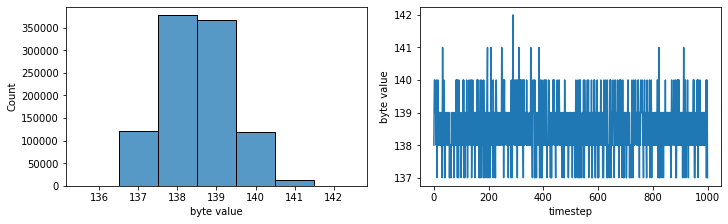

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


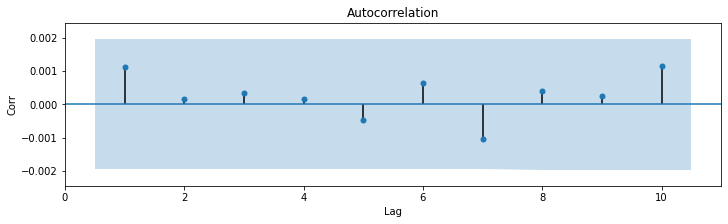

,Ljung-Box Test p-val
lag,
1,0.266569
2,0.531736
3,0.712855
4,0.845272
5,0.900483
6,0.919633
7,0.876288
8,0.918172
9,0.950757


INFO:TRNG Analysis:Doing experiment data_v2/PR_Card_2/220928_CVa4


data_v2/PR_Card_2/220928_CVa4


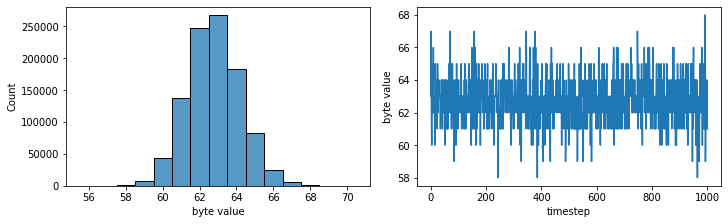

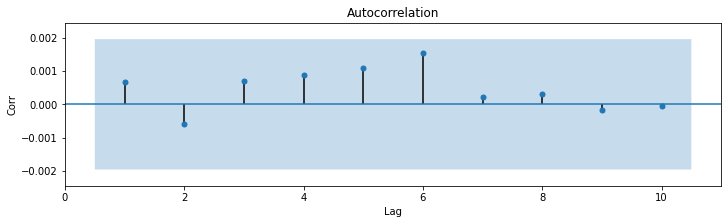

,Ljung-Box Test p-val
lag,
1,0.506165
2,0.677531
3,0.737661
4,0.733218
5,0.665921
6,0.469634
7,0.581593
8,0.675647
9,0.761893


INFO:TRNG Analysis:Doing experiment data_v2/PR_Card_2/220928_CVa4


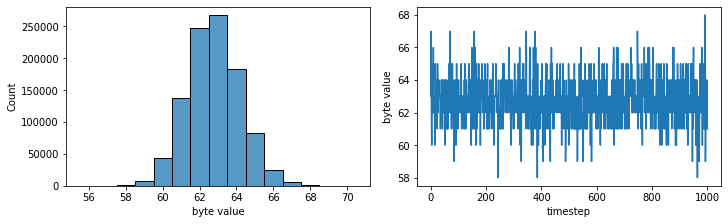

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


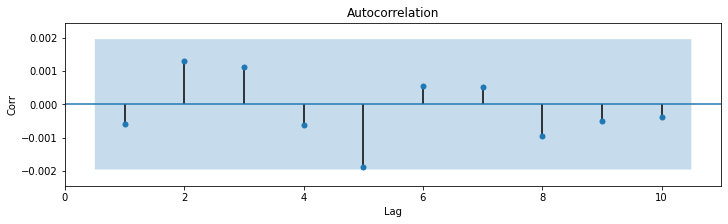

,Ljung-Box Test p-val
lag,
1,0.561615
2,0.366477
3,0.348040
4,0.449094
5,0.199956
6,0.269281
7,0.344254
8,0.361330
9,0.433869


INFO:TRNG Analysis:Doing experiment data_v2/PR_Card_2/220928_CVa2


data_v2/PR_Card_2/220928_CVa2


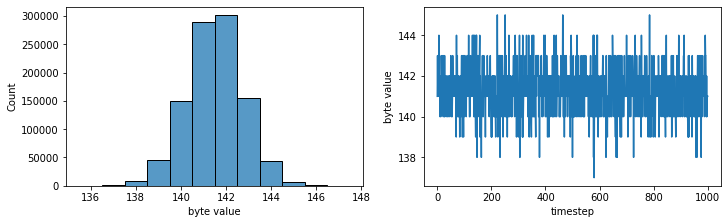

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


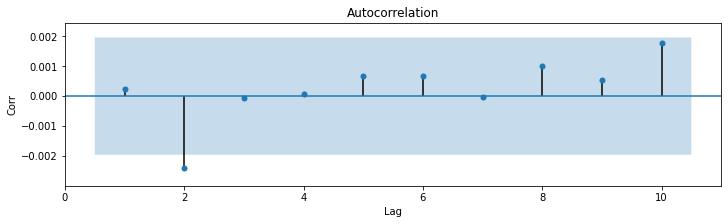

,Ljung-Box Test p-val
lag,
1,0.801097
2,0.054490
3,0.120517
4,0.212443
5,0.278084
6,0.345322
7,0.455987
8,0.456223
9,0.527052


INFO:TRNG Analysis:Doing experiment data_v2/PR_Card_2/220928_CVa2


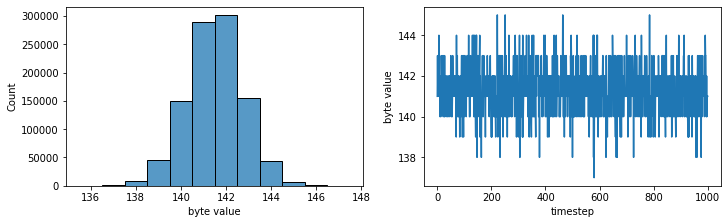

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


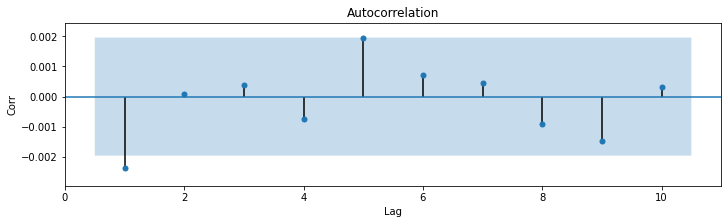

,Ljung-Box Test p-val
lag,
1,0.017880
2,0.060265
3,0.123762
4,0.178444
5,0.074141
6,0.102500
7,0.148630
8,0.168698
9,0.130328


INFO:TRNG Analysis:Doing experiment data_v3/220929_SFa4_DBv11-12


data_v3/220929_SFa4_DBv11-12


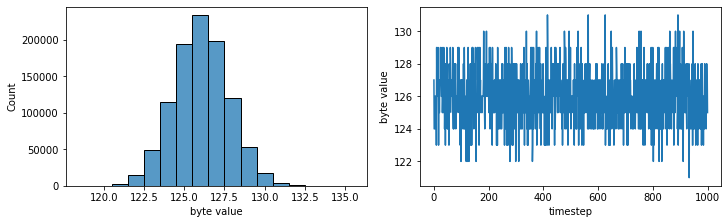

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


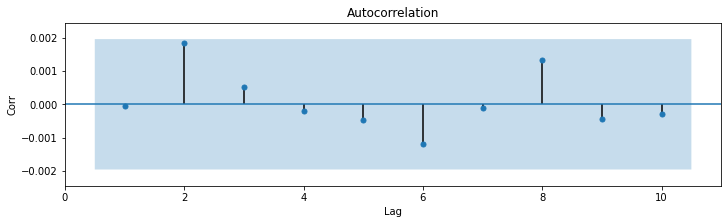

,Ljung-Box Test p-val
lag,
1,0.967270
2,0.178500
3,0.295086
4,0.440724
5,0.555179
6,0.498286
7,0.614324
8,0.516652
9,0.597516


INFO:TRNG Analysis:Doing experiment data_v3/220929_SFa4_DBv11-12


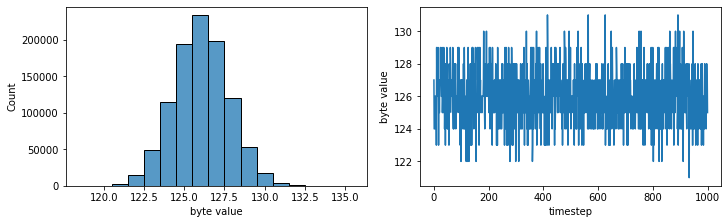

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


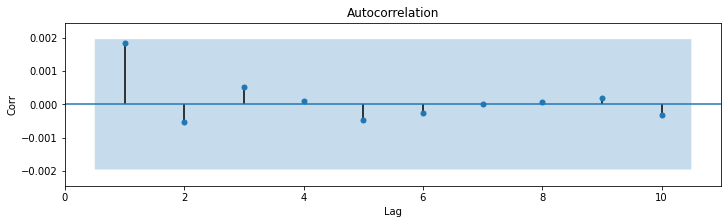

,Ljung-Box Test p-val
lag,
1,0.063453
2,0.154986
3,0.261770
4,0.405009
5,0.516248
6,0.636559
7,0.744992
8,0.828914
9,0.888015


INFO:TRNG Analysis:Doing experiment data_v3/220929_SFa2_DBv11-12


data_v3/220929_SFa2_DBv11-12


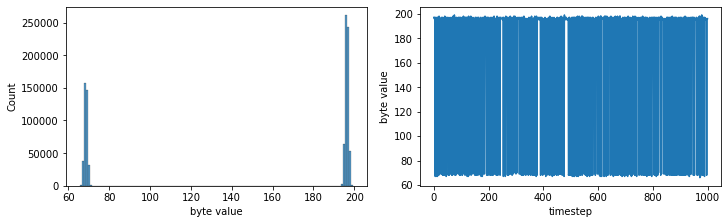

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


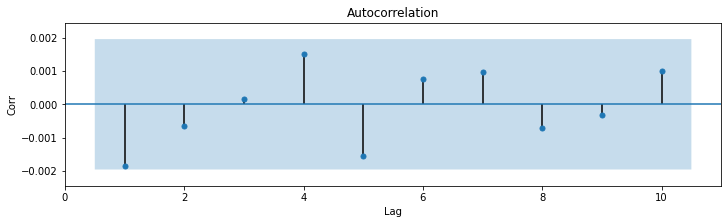

,Ljung-Box Test p-val
lag,
1,0.064305
2,0.147090
3,0.277085
4,0.186956
5,0.128608
6,0.167305
7,0.184180
8,0.225171
9,0.296932


INFO:TRNG Analysis:Doing experiment data_v3/220929_SFa2_DBv11-12


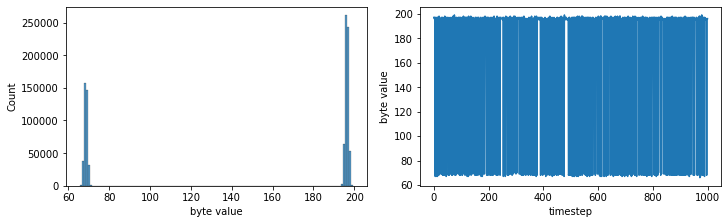

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


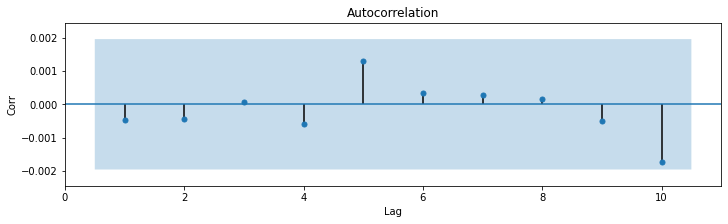

,Ljung-Box Test p-val
lag,
1,0.627776
2,0.802086
3,0.930672
4,0.938680
5,0.774666
6,0.852767
7,0.909924
8,0.949335
9,0.964464


INFO:TRNG Analysis:Doing experiment data_v3/220929_SFa1_DBv11-12


data_v3/220929_SFa1_DBv11-12


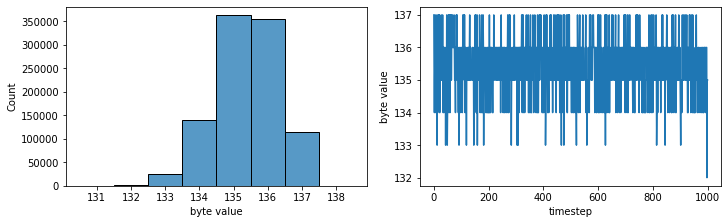

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


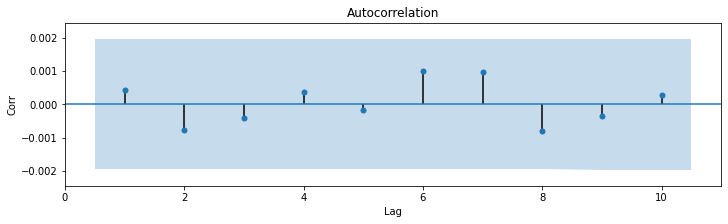

,Ljung-Box Test p-val
lag,
1,0.664287
2,0.676098
3,0.815076
4,0.898730
5,0.953800
6,0.909744
7,0.881397
8,0.883951
9,0.923311


INFO:TRNG Analysis:Doing experiment data_v3/220929_SFa1_DBv11-12


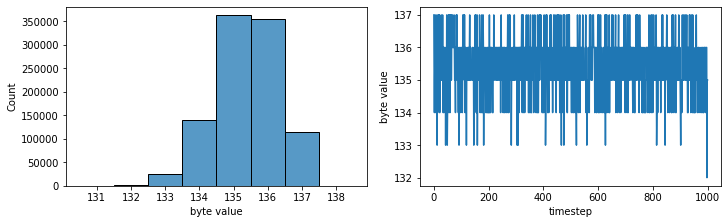

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


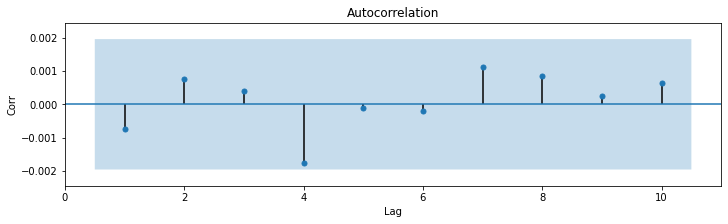

,Ljung-Box Test p-val
lag,
1,0.455539
2,0.561569
3,0.728083
4,0.348667
5,0.484886
6,0.609535
7,0.568929
8,0.593655
9,0.684669


In [ ]:
for path in Path('').rglob(r'*cnt.bin'):
  exp_name = path.parent
  print(exp_name)
  for fn in [last_bit,diff_last_bit]:
    with mlflow.start_run(run_name=exp_name):
      logger.info(f'Doing experiment {exp_name}')
      bytes_data = get_bytes_data(path)
      analyze_series(bytes_data,postprocess_fn=fn)